In [13]:
import numpy as np
import pandas as pd
import ssl
import copy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re
import random
from pprint import pprint

from imblearn.over_sampling import RandomOverSampler,SMOTE, ADASYN, SMOTENC, SVMSMOTE
from imblearn.pipeline import make_pipeline

from imblearn.under_sampling import RandomUnderSampler


from sklearn.metrics import hamming_loss, roc_auc_score
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split 

from nltk.stem import PorterStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
import wordcloud

from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_curve
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC, NuSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer


import scikitplot as skplt
import matplotlib.pyplot as plt

from keras import optimizers
from keras.losses import binary_crossentropy
from keras.metrics import binary_accuracy
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping

from scipy.special import softmax

ssl._create_default_https_context = ssl._create_unverified_context

In [14]:
def clean_statement(statement):
#     x = re.sub('-', ' ', x)
    statement = re.sub('$', ' ', statement)
    statement = re.sub('[^A-Za-z]+', ' ', statement)
    statement = re.sub('[,|.|?|\n]|\t', '', statement)
    statement = re.sub('n\'t', ' ', statement)
    statement = re.sub('submission|submissions|Submission|submission|th ', '', statement)
    statement = re.sub('one|two|given|need', '', statement)
    
    return statement

In [15]:
def process_problem_statement(q_statement):
    
    q_statement = clean_statement(q_statement)
    
#     q_statement = re.sub('[^A-Za-z]+', ' ', q_statement)
    
    tokens = word_tokenize(q_statement)
    
    stoplist = set(stopwords.words('english'))
    
    word_list = [i for i in q_statement.lower().split() if i not in stoplist]
    
    ps = PorterStemmer()
    
#     word_list = [ps.stem(word) for word in word_list]
    
    q_statement = ' '.join(word_list)
    
#     print(q_statement)
    
    return q_statement

In [16]:
def process_problem_solution(solution):
    
#     solution = clean_statement(solution)
    
    tokens = word_tokenize(solution)
    
    stoplist = set(stopwords.words('english'))
    
    word_list = [i for i in solution.lower().split() if i not in stoplist]
    
#     ps = PorterStemmer()
    
#     word_list = [ps.stem(word) for word in word_list]
    
    solution = ' '.join(word_list)
    
#     print(q_statement)
    
    return solution

In [17]:
def process_time_taken(time_col):
#     print(time_col.split())
    return time_col.split()[0]

In [18]:
def process_tags(all_tags_list,tag_col):
    
#     print(tag_col)
    tags_present = list(re.split(',',tag_col))
    return tags_present
    
#     tags_set = set(tags_present)
#     tags_diff = tags_set.difference(set(all_tags_list))
#     print(tags_diff)
#     new_set = tags_set.difference(tags_diff)
# #     print(new_set)
#     return list(new_set)
    

In [19]:
def get_all_distinct_tags(tags_col):
    
    tags_list = []
    
    t_sets = set(tags_list)
    
    for row in tags_col:
#         print(row)
        t_list = re.split(',',row)
#         print(t_list)
        t_sets = t_sets.union(set(t_list))
#         print(t_sets)
    tags_list = list(t_sets)
    
    stoplist = set(stopwords.words('english'))
    
    word_list = [i for i in tags_list if i not in stoplist]
    
    return tags_list

In [20]:
# tag list obtained from the dataset
# global tags_list

tags_list = ['dsu', 'trees', 'chinese remainder theorem', 'sortings', 'games', 'implementation', 'bitmasks',
              '*special', 'hashing', 'geometry', 'two pointers', 'combinatorics', 'flows', 'strings',
              'probabilities', 'data structures', 'ternary search', 'greedy', 'math', 'matrices',
              'divide and conquer', 'dfs and similar', 'constructive algorithms', 'brute force', 'dp',
              '2-sat', 'graph matchings', 'binary search', 'number theory', 'graphs', 'fft', 'shortest paths',
              'schedules', 'meet-in-the-middle', 'string suffix structures', 'expression parsing']



In [21]:
def plot_class_distribution(Y,classes):
    
    count_list = [0]*Y.shape[1]
    
    for index in range(Y.shape[1]):
        
        count_list[index] = np.sum(Y[:,index])/Y.shape[0]
    
    plt.figure(figsize=(10, 10), dpi=100)
    
    plt.barh(classes,count_list, align='center', alpha=0.5)
#     plt.bar(np.arange(Y.shape[1]),count_list, align='center', alpha=0.5)
#     plt.plot(np.arange(Y.shape[1]),count_list)
    plt.show()
    

In [22]:
def data_preprocessing():
    
#     df = pd.read_csv("codeforces_question_v5.csv")

    df = pd.read_csv("t3_tagged_codeforces.csv")
    df = df.drop(['id','name','author'],axis = 1)
    df = df[df.solution != "no code found"]
    df = df.dropna()
    
    global distinct_tags
    
    distinct_tags = get_all_distinct_tags(df["tags"])
    
    df["problem statement"] = [process_problem_statement(x) for x in df["problem statement"]]
    df["solution"] = [process_problem_solution(x) for x in df["solution"]]
    df["time_taken"] = [process_time_taken(x) for x in df["time_taken"]]
    
    X = copy.deepcopy(df["solution"]+df["time_taken"])
#     X = copy.deepcopy(df["solution"])
    Y = [process_tags(distinct_tags,x) for x in df["tags"]]

    mlb = MultiLabelBinarizer()
    Y = mlb.fit_transform(Y)
    print(mlb.classes_)
    
    plot_class_distribution(Y,mlb.classes_)
    
#     print(X.shape,Y.shape)
#     X = np.array(X,dtype=np.str).reshape(-1,1)
    
#     X = pd.DataFrame(X).values
#     X = X.values.reshape(-1,1)
    
#     vectorizer = TfidfVectorizer()
#     X = vectorizer.fit_transform(X)
    
#     print(type(X))
#     print(X.shape)
    
#     print(X.shape,Y.shape)

    #lossing one dimension/column
#     ros = RandomOverSampler(random_state=0)
#     X, Y = ros.fit_resample(X, Y)
#     print(type(X))
#     print(X)
#     X = pd.DataFrame(X)
#     X, Y = SVMSMOTE().fit_resample(X, Y)
#     print(Y)
#     print(X.shape,Y.shape)
    
#     Y = np.c_[Y,np.zeros(Y.shape[1])]

#     z = np.zeros((Y.shape[0],1), dtype=np.int64)
#     Y = np.append(Y, np.zeros((Y.shape[0],1),dtype=np.str), axis=1)
#     Y = pd.DataFrame(Y)
#     print(X.shape,Y.shape)
    
#     plot_class_distribution(Y,mlb.classes_)
    
    return X, Y, mlb

['*special' '2-sat' 'binary search' 'bitmasks' 'brute force'
 'chinese remainder theorem' 'combinatorics' 'constructive algorithms'
 'data structures' 'dfs and similar' 'divide and conquer' 'dp' 'dsu'
 'expression parsing' 'fft' 'flows' 'games' 'geometry' 'graph matchings'
 'graphs' 'greedy' 'hashing' 'implementation' 'math' 'matrices'
 'meet-in-the-middle' 'number theory' 'probabilities' 'schedules'
 'shortest paths' 'sortings' 'string suffix structures' 'strings'
 'ternary search' 'trees' 'two pointers']


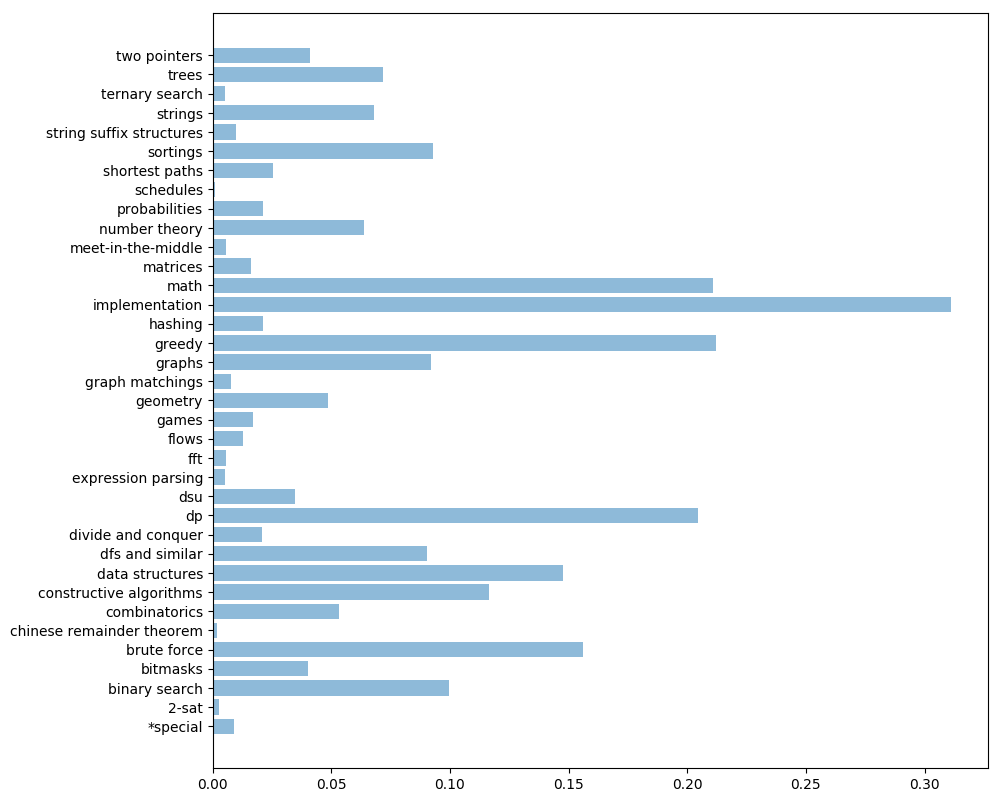

<class 'pandas.core.series.Series'> <class 'numpy.ndarray'>
(31830, 36)
(31830, 36)
On Train data
hamming_loss:  0.004151394561385136
recall_score:  0.952813626556239
precision_score:  0.9831471622888021
f1_score:  0.9674931607250219
roc_auc_score:  0.9738071964650468
[0 1]
[0 1]


On Validation data
(7958, 36)
(7958, 36)
hamming_loss:  0.016077462232275
recall_score:  0.815139613708506
precision_score:  0.9303907541241733
f1_score:  0.8675535402761968
[0 1]
[0 1]


roc_auc_score:  0.8997008275794331


Actual vs Predicted
('bitmasks', 'combinatorics', 'dp', 'math', 'number theory') => bitmasks, combinatorics, dp, math, number theory
('dp', 'dsu', 'graphs') => dp, dsu, graphs
('dfs and similar', 'number theory', 'trees') => dfs and similar, number theory, trees
('two pointers',) => greedy, sortings
('binary search', 'constructive algorithms', 'data structures') => binary search, constructive algorithms, data structures
('binary search', 'math') => 
('binary search', 'greedy', 'implement

('implementation',) => implementation
('brute force', 'greedy', 'implementation', 'math') => brute force, greedy, implementation, math
('implementation',) => implementation
('brute force', 'graphs') => brute force
('implementation',) => implementation
('greedy', 'implementation') => greedy, implementation
('dp',) => dp
('flows', 'greedy') => flows, greedy
('implementation',) => implementation
('brute force', 'implementation', 'math') => brute force, implementation, math
('implementation',) => implementation
('brute force', 'implementation') => brute force, implementation
('sortings',) => 
('implementation',) => implementation
('dp', 'trees', 'two pointers') => dp, trees, two pointers
('binary search', 'math', 'two pointers') => binary search, math, two pointers
('brute force', 'dp', 'number theory') => number theory
('binary search', 'data structures', 'greedy', 'sortings') => binary search, data structures, greedy, sortings
('implementation',) => implementation
('dp', 'math') => combi

In [23]:
#validation_fraction = 0.2,early_stopping = True,learning_rate = 'adaptive',eta0 = 0.001,verbose = 2

global distinct_tags

X,Y, mlb = data_preprocessing()
# X = pd.DataFrame(X,dtype=np.str).values
# print(X)
# print(Y)
# print(type(X),type(Y))
# print(X.shape,Y.shape)

X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size = 0.2, random_state = 0)

# plot_class_distribution(Y_train.values,mlb.classes_)
# plot_class_distribution(Y_validation.values,mlb.classes_)

classifier = make_pipeline(
    CountVectorizer(ngram_range = (1,2),binary = True),
    TfidfTransformer(norm = 'l2',sublinear_tf = True),
#     SMOTENC(categorical_features=[0],random_state=0),
    OneVsRestClassifier(LinearSVC(penalty="l2",loss="squared_hinge",tol=1,random_state=0,max_iter=1000,C = 1)))

    
# classifier = Pipeline([
#     ('vectorizer', CountVectorizer(ngram_range = (1,5),binary = True)),
#     ('tfidf', TfidfTransformer(norm = 'l2',sublinear_tf = False)),
#     ('clf', OneVsRestClassifier(NuSVC(nu = 0.001,kernel = "rbf",verbose = True,tol=2
#             ,random_state=0, max_iter=10000,decision_function_shape = 'ovr')))])

print(type(X_train), type(Y_train))
classifier.fit(X_train, Y_train)

predicted = classifier.predict(X_train)
print(Y_train.shape)
print(predicted.shape)
y_labels_predicted = mlb.inverse_transform(predicted)
y_labels_actual = mlb.inverse_transform(Y_train)

print("On Train data")
print("hamming_loss: ",hamming_loss(Y_train,predicted))
print("recall_score: ",recall_score(Y_train,predicted,average = 'weighted'))
print("precision_score: ",precision_score(Y_train,predicted,average = 'weighted'))
print("f1_score: ",f1_score(Y_train,predicted,average = 'weighted'))



print("roc_auc_score: ",roc_auc_score(Y_train,predicted,average = 'weighted'))
# print("confusion_matrix: ",confusion_matrix(Y_train,predicted))
print(np.unique(Y_train))
print(np.unique(predicted))
print()
print()

# print("Actual vs Predicted")

# for item, labels in zip(y_labels_actual, y_labels_predicted):
#         print('{0} => {1}'.format(item, ', '.join(labels)))

# print()
# print()


print("On Validation data")
predicted = classifier.predict(X_validation)

y_labels_predicted = mlb.inverse_transform(predicted)
y_labels_actual = mlb.inverse_transform(Y_validation)
# print(predicted)
print(Y_validation.shape)
print(predicted.shape)
print("hamming_loss: ",hamming_loss(Y_validation,predicted))
print("recall_score: ",recall_score(Y_validation,predicted,average = 'weighted'))
print("precision_score: ",precision_score(Y_validation,predicted,average = 'weighted'))
print("f1_score: ",f1_score(Y_validation,predicted,average = 'weighted'))


print(np.unique(Y_validation))
print(np.unique(predicted))
print()
print()

print("roc_auc_score: ",roc_auc_score(Y_validation,predicted,average = 'weighted'))
# print("confusion_matrix: ",confusion_matrix(Y_validation,predicted))
print()
print()
print("Actual vs Predicted")

for item, labels in zip(y_labels_actual, y_labels_predicted):
        print('{0} => {1}'.format(item, ', '.join(labels)))

# print(np.unique(Y_validation))
# print(np.unique(predicted))

# for col_index in range(Y_validation.shape[1]):
    
#     print(confusion_matrix(Y_validation[:,col_index],predicted[:,col_index]))
        
        
# classifier2 = Pipeline([
#     ('vectorizer', CountVectorizer()),
#     ('tfidf', TfidfTransformer()),
#     ('clf', LinearSVC(penalty="l2",loss="squared_hinge",dual=True,tol=0.0000001, C=1.0, 
#             multi_class="ovr",random_state=0, max_iter=10000))])

# print(X_train.shape)

        
        
# print()
# print()

# actual_y = []
# predicted_list = []

# for index in range(len(distinct_tags)-1):
    
#     print('Processing tag: {}'.format(distinct_tags[index]))
#     classifier2.fit(X_train, Y[:,index])
#     predicted = classifier2.predict(X_test)
    
# #     print(predicted)
# #     print("##########################################################")
# #     print(target_names.iloc[:,index])
#     #     print(mlb.fit_transform(target_names)[:,index])
    
# #     actual_y.append(mlb.fit_transform(target_names)[:,index])
# #     predicted_list.append(predicted)
    
#     print('Test accuracy is {}'.format(accuracy_score(mlb.fit_transform(target_names)[:,index], predicted)))
#     print('Test recall_score is {}'.format(recall_score(mlb.fit_transform(target_names)[:,index], predicted)))
#     print('Test precision_score is {}'.format(precision_score(mlb.fit_transform(target_names)[:,index], predicted)))
#     print('Test f1_score is {}'.format(f1_score(mlb.fit_transform(target_names)[:,index], predicted)))
    
#     print()
    
#     y_true = mlb.fit_transform(target_names)[:,index]
#     y_probas = predicted
#     fpr, tpr, thresholds = roc_curve(y_true, y_probas, pos_label=0)

# #     print("$$$$$$$$$$$$$$$$$$$$$$$$")
# #     print(fpr, tpr, thresholds)
# #     print("$$$$$$$$$$$$$$$$$$$$$$$$")
    
#     # Print ROC curve
#     plt.plot(fpr,tpr)
#     plt.show() 

#     # Print AUC
#     auc = np.trapz(tpr,fpr)
#     print('AUC:', auc)

In [24]:
def generate_tag_frequency(Y):
    
    freq = [0]*Y.shape[1]
    
    for col in range(Y.shape[1]):
        
        for row in list(Y[:,col]):
            if row == 1:
                
                freq[col] += 1
        
    return np.array(freq) 

In [25]:
def handle_class_imbalance(y_predicted,tag_freq):
    
    epsilon = 10
    
    for row_index in range(y_predicted.shape[0]):
        
        for col_index in range(y_predicted.shape[1]):
            
            y_predicted[row_index,col_index] /= tag_freq[col_index] + epsilon 
    
    return y_predicted

['*special' '2-sat' 'binary search' 'bitmasks' 'brute force'
 'chinese remainder theorem' 'combinatorics' 'constructive algorithms'
 'data structures' 'dfs and similar' 'divide and conquer' 'dp' 'dsu'
 'expression parsing' 'fft' 'flows' 'games' 'geometry' 'graph matchings'
 'graphs' 'greedy' 'hashing' 'implementation' 'math' 'matrices'
 'meet-in-the-middle' 'number theory' 'probabilities' 'schedules'
 'shortest paths' 'sortings' 'string suffix structures' 'strings'
 'ternary search' 'trees' 'two pointers']


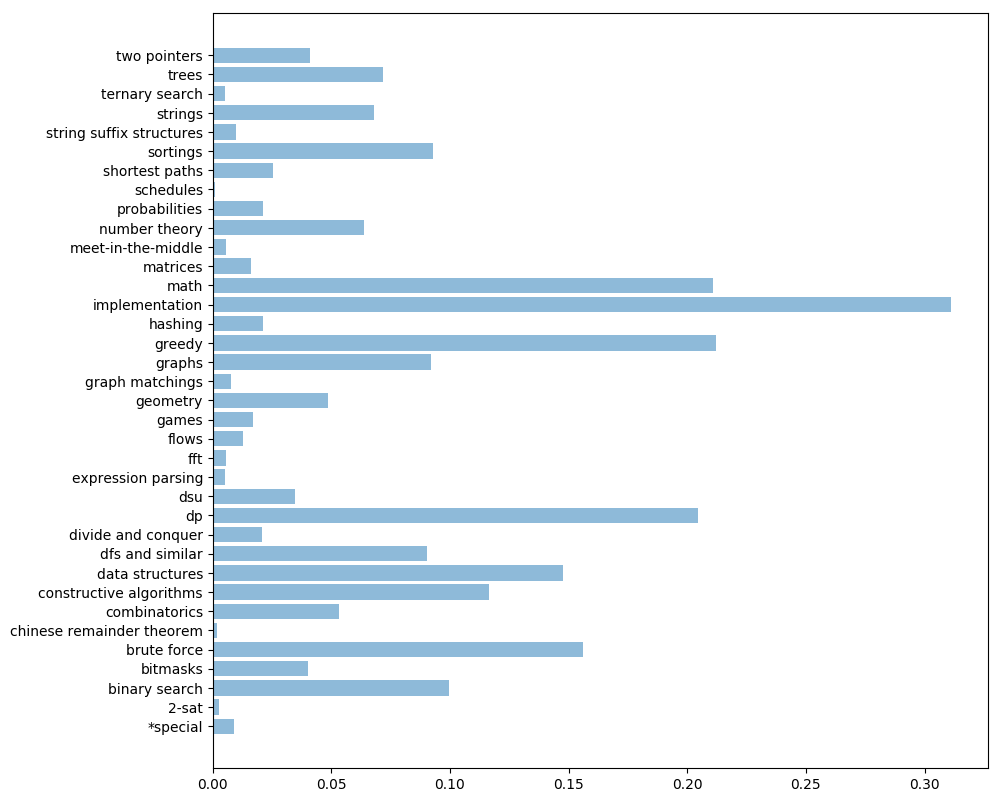

In [33]:
X,Y, mlb = data_preprocessing()

In [36]:
# X_train,X_test,y_train,y_test = data_preprocessing()


# X,Y, mlb = data_preprocessing()


# mlb = MultiLabelBinarizer()
# Y = mlb.fit_transform(y_train)

tag_freq = generate_tag_frequency(Y)

n_most_common_words = 2000
max_len = 500

tokenizer = Tokenizer(num_words=n_most_common_words, filters=';/@?`~', lower=True)
tokenizer.fit_on_texts(X.values)
sequences = tokenizer.texts_to_sequences(X.values)
print(sequences)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X = pad_sequences(sequences, maxlen=max_len)

# print(X)
# print(X.shape)
# print(Y.shape)

X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size = 0.2, random_state = 0)

epochs = 2
emb_dim = 250
batch_size = 100

print((X_train.shape, Y_train.shape, X_validation.shape, Y_validation.shape))

model = Sequential()
model.add(Embedding(n_most_common_words, emb_dim, input_length=X.shape[1]))
# model.add(SpatialDropout1D(0.7))
model.add(LSTM(128, dropout=0.1, recurrent_dropout=0.3))
# model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(36, activation='sigmoid'))


sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(loss=binary_crossentropy, metrics=['binary_accuracy'],optimizer=sgd)

print(model.summary())
callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.01)]
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=callbacks)


y_predicted = model.predict(X_validation)

accr = model.evaluate(X_validation)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

print(y_predicted)

print('Test accuracy is {}'.format(accuracy_score(Y_validation, y_predicted)))
print("Hamming_loss: ",hamming_loss(Y_validation,predicted))
print('Test recall_score is {}'.format(recall_score(Y_validation, y_predicted)))
print('Test precision_score is {}'.format(precision_score(Y_validation, y_predicted)))
print('Test f1_score is {}'.format(f1_score(Y_validation, y_predicted)))
print("roc_auc_score: ",roc_auc_score(Y_validation,predicted,average = 'weighted'))

# print(y_predicted)

# y_predicted = handle_class_imbalance(y_predicted,tag_freq)

# print(y_predicted)

# threshold = 0.03

# m = []
# for row in y_predicted:
# #     m.append(softmax(row))
#     m.append(row)
    
# final_prediction = []

# print(m)

# for row in m:
#     temp = []
#     val = np.sort(row)[-3]
#     for item in row:
#         if item < val:
#             temp.append(0)
#         else:
#             temp.append(1)
#     final_prediction.append(temp)
    
# print(final_prediction)    
# print(y_test.shape)
# print(np.array(final_prediction).shape)
# print()
# print("hamming_loss: ",hamming_loss(np.array(final_prediction),y_test))
# print()

# all_labels = mlb.inverse_transform(np.array(final_prediction))
# y_labels = mlb.inverse_transform(y_test)

# for item, labels in zip(y_labels, all_labels):
#         print('{0} => {1}'.format(item, ', '.join(labels)))

# acc = history.history['binary_accuracy']
# val_acc = history.history['val_acc']
# loss = history.history['loss']
# val_loss = history.history['val_loss']

# epochs = range(1, len(acc) + 1)

# plt.plot(epochs, acc, 'bo', label='Training acc')
# plt.plot(epochs, val_acc, 'b', label='Validation acc')
# plt.title('Training and validation accuracy')
# plt.legend()

# plt.figure()

# plt.plot(epochs, loss, 'bo', label='Training loss')
# plt.plot(epochs, val_loss, 'b', label='Validation loss')
# plt.title('Training and validation loss')
# plt.legend()

# plt.show()



AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [ ]:
l = np.array([[1,2,3,4],[2,4,6,7],[45,67,99,2]])
print(l)
m = []
for row in l:
    print(row)
    m.append(softmax(row))
    
m = np.array(m)
print(m)

k = [3,2,4,5,-1,-5,6]

np.sort(k)[-2]

In [ ]:
def comments():
    
    #     global tags_list
    #     print(set(distinct_tags).difference(set(tags_list)))


    #     print(df["tags"])  
    #     print(df[df['difficulty'] == ''])

    #     np.where(df.applymap(lambda x: x == ''))

    #     nan_rows = df[df['difficulty'].isna()]
    #     print(nan_rows)
    #     print(df["difficulty"].describe())
    #     print(df["solution"].describe())

    #     print(df["time_taken"])


    #     one_hot = pd.get_dummies(df['tags'])
    #     # Drop column B as it is now encoded
    #     df = df.drop('tags',axis = 1)
    #     # Join the encoded df
    #     df = df.join(one_hot)
    #     print(df)


    #     print(distinct_tags)
    #     print(df.describe())
    #     print(df["problem statement"])
    #     print(df["tags"])

    #     cloud = wordcloud.WordCloud(background_color='black', max_font_size=60, relative_scaling=.5).generate(' '.join(df["solution"]))
    #     plt.figure(figsize=(20,10))
    #     plt.axis('off')
    #     plt.imshow(cloud);
    
    
    #############################################################################################
    
    #OneVsRestClassifier(MultinomialNB())
    #OneVsRestClassifier(LinearSVC())
    #OneVsRestClassifier(LogisticRegression(solver='sag'))

    # classifier.fit(X_train, Y)
    # predicted = classifier.predict(X_test)
    # all_labels = mlb.inverse_transform(predicted)
    # predicted = copy.deepcopy(all_labels)
    # print(list(map(list, all_labels)))
    # all_labels = list(map(list, all_labels))
    # print(all_labels)
    # all_labels = all_labels.append(distinct_tags)
    # target_names.append(distinct_tags)

    # print(target_names)
    # print(all_labels)
    
    # print("Accuracy: ",accuracy_score(mlb.fit_transform(target_names),mlb.fit_transform(all_labels)))
    # print()
    # for item, labels in zip(target_names, predicted):
    #     print('{0} => {1}'.format(item, ', '.join(labels)))
    
    pass

In [ ]:
X,Y, mlb = data_preprocessing()

ros = RandomOverSampler()
# print(type(X),type(y))
print(X.shape,y.shape)
# print(X,y)

# z = np.zeros((Y.shape[0],1),dtype=np.int64)
# Y = np.append(Y, z, axis=1)
y=Y
X = pd.DataFrame(X)
print(type(X),type(y))
print(X.shape,y.shape)
# print(y)

X_resampled, y_resampled = ros.fit_resample(X, y)
print(X_resampled.shape,y_resampled.shape)
print(type(X_resampled),type(y_resampled))
print(X_resampled,y_resampled)
# from collections import Counter
# print(sorted(Counter(y_resampled).items()))